In [1]:
import numpy as np
import pandas as pd
import re
import unicodedata
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

random_state = 14

# Read Data

In [2]:
train_set = pd.read_json('whats-cooking/train.json/train.json')
test_set = pd.read_json('whats-cooking/test.json/test.json')
train_set

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [3]:
test_set

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."
...,...,...
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo..."
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc..."
9941,22339,"[black pepper, salt, parmigiano reggiano chees..."
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato..."


# Data visualisation
Plot number of recipes for each cuisine.

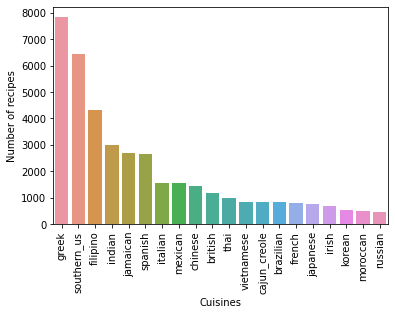

In [4]:
cuisines = train_set['cuisine'].unique()
occurences = train_set['cuisine'].value_counts()
ax = sns.barplot(cuisines, occurences)
plt.xlabel('Cuisines')
plt.ylabel('Number of recipes')
plt.xticks(rotation=90)
plt.show()

# Data transformation
## Find no-typical data
Firstable, let's print ingredients with no-typical characters (different than a-z and A-Z) to analyze them and take appriopriate steps to process data set.

In [5]:
def findStrangeIngredients(ingredients):
    strangeIngredients = set()
    for ingredientList in ingredients:
        for ingredient in ingredientList:
            if not re.findall(r'^[a-zA-Z ]+$', ingredient):
                strangeIngredients.add(ingredient)
    return strangeIngredients

strangeIngredients = findStrangeIngredients(train_set['ingredients'])
print(f'Number of strange ingredients: {len(strangeIngredients)}')
strangeIngredients

Number of strange ingredients: 455


{'(    oz.) tomato sauce',
 '(   oz.) tomato paste',
 '(10 oz.) frozen chopped spinach',
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry',
 '(14 oz.) sweetened condensed milk',
 '(14.5 oz.) diced tomatoes',
 '(15 oz.) refried beans',
 '1% low-fat buttermilk',
 '1% low-fat chocolate milk',
 '1% low-fat cottage cheese',
 '1% low-fat milk',
 '2 1/2 to 3 lb. chicken, cut into serving pieces',
 '2% low fat cheddar chees',
 '2% low-fat cottage cheese',
 '2% lowfat greek yogurt',
 '2% milk shredded mozzarella cheese',
 '2% reduced-fat milk',
 '25% less sodium chicken broth',
 '33% less sodium cooked deli ham',
 '33% less sodium cooked ham',
 '33% less sodium ham',
 '33% less sodium smoked fully cooked ham',
 '40% less sodium taco seasoning',
 '40% less sodium taco seasoning mix',
 '7 Up',
 '8 ounc ziti pasta, cook and drain',
 '95% lean ground beef',
 'BACARDI® Mixers Margarita Mix',
 'BACARDI® Superior',
 "BREAKSTONE'S Sour Cream",
 'Barilla Oven-Ready Lasagne',
 'Bengali 5 Spice'

In [6]:
def findStrangeCuisines(cuisines):
    strangeCuisines = set()
    for cuisine in cuisines:
        if not re.findall(r'^[a-z ]+$', cuisine):
            strangeCuisines.add(cuisine)
    return strangeCuisines

strangeCuisines = findStrangeCuisines(train_set['cuisine'])
strangeCuisines

{'cajun_creole', 'southern_us'}

## Lemmatization
To simplify data set we can lemmatize it (change different forms of word to the basic one, for example tomatoes to tomato).

In [7]:
def lemmatizeIngredients(ingredients):
    return [" ".join([WordNetLemmatizer().lemmatize(word).lower() for word in ingredient.split()]) for ingredient in ingredients]
    


## Eliminate accents
We can see that some words contain some special characters from different languages. We change all of them to english characters for unification.

In [8]:
def convertUnicodeCharacters(ingredients):
    return [''.join(c for c in unicodedata.normalize('NFD', ingredient)
                  if unicodedata.category(c) != 'Mn') for ingredient in ingredients]

## Remove additional information
Some of the ingredients contain info about amount (oz.) or processing type (diced, peeled, ...) so we remove them with use of regular expresions. Also remove additional white characters and all special characters at the end.

In [9]:
def removeAdditionalInfoFromIngredients(ingredients):
    ingredients = [re.sub(r'\(.*oz.*\)( )?|chopped|crushed|diced|frozen|ground|minced|peeled|powder|sliced|whole', '', ingredient) for ingredient in ingredients]
    ingredients = [re.sub(r'feta cheese crumbles', 'feta cheese', ingredient) for ingredient in ingredients]
    ingredients = [re.sub(r',(.+?)$', '', ingredient) for ingredient in ingredients]
    ingredients = [re.sub(r'[^a-z ]', '', ingredient) for ingredient in ingredients]
    ingredients = [re.sub(r' +', ' ', ingredient.strip()) for ingredient in ingredients]
    return ingredients

## Apply transformation

In [10]:
def transformData(ingredients):
    ingredients = lemmatizeIngredients(ingredients)
    ingredients = convertUnicodeCharacters(ingredients)
    ingredients = removeAdditionalInfoFromIngredients(ingredients)
    return ingredients


In [11]:
train_set['ingredients'] = train_set['ingredients'].apply(transformData)
train_set

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olive, grape tomato, g..."
1,25693,southern_us,"[plain flour, pepper, salt, tomato, black pepp..."
2,20130,filipino,"[egg, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallot, cornflour, cayenne pep..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[kraft zesty italian dressing, purple onion, b..."
39771,2238,irish,"[egg, citrus fruit, raisin, sourdough starter,..."
39772,41882,chinese,"[boneless chicken skinless thigh, garlic, stea..."


We can see that all non typical ingredients are transformed to casual ones.

In [12]:
strangeIngredients = findStrangeIngredients(train_set['ingredients'])
print(f'Number of strange ingredients: {len(strangeIngredients)}')
strangeIngredients

Number of strange ingredients: 0


set()

## Test set processing
Analogical transformation is applied to test set.

In [13]:
strangeIngredients = findStrangeIngredients(test_set['ingredients'])
print(f'Number of strange ingredients: {len(strangeIngredients)}')
strangeIngredients

Number of strange ingredients: 258


{'(    oz.) tomato sauce',
 '(14.5 oz.) diced tomatoes',
 '1% low-fat buttermilk',
 '1% low-fat cottage cheese',
 '1% low-fat milk',
 '2% low-fat cottage cheese',
 '2% lowfat greek yogurt',
 '2% reduced fat chocolate milk',
 '2% reduced-fat milk',
 '33% less sodium cooked deli ham',
 '33% less sodium smoked ham',
 '40% less sodium taco seasoning',
 '50% less sodium black beans',
 '7 Up',
 '8 ounc ziti pasta, cook and drain',
 '95% lean ground beef',
 'Bengali 5 Spice',
 'Bertolli Tomato & Basil Sauce',
 'Bertolli® Alfredo Sauce',
 'Bertolli® Classico Olive Oil',
 'Bisquick Original All-Purpose Baking Mix',
 "Campbell's Condensed Cheddar Cheese Soup",
 "Campbell's Condensed Cream of Chicken Soup",
 'Country Crock® Spread',
 'Diamond Crystal® Kosher Salt',
 'Dutch-processed cocoa powder',
 "Frank's® RedHot® Original Cayenne Pepper Sauce",
 "French's Spicy Brown Mustard",
 'Green Giant™ Steamers™ Niblets® frozen corn',
 'Green Giant™ frozen chopped spinach',
 "Hellmann''s Light Mayonnaise

In [14]:
test_set['ingredients'] = test_set['ingredients'].apply(transformData)
test_set

,id,ingredients
0,18009,"[baking, egg, allpurpose flour, raisin, milk, ..."
1,28583,"[sugar, egg yolk, corn starch, cream of tartar..."
2,41580,"[sausage link, fennel bulb, frond, olive oil, ..."
3,29752,"[meat cut, file, smoked sausage, okra, shrimp,..."
4,35687,"[black pepper, salt, sausage casing, leek, par..."
...,...,...
9939,30246,"[large egg yolk, fresh lemon juice, sugar, bou..."
9940,36028,"[hot sauce, butter, sweet potato, adobo sauce,..."
9941,22339,"[black pepper, salt, parmigiano reggiano chees..."
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato..."


In [15]:
strangeIngredients = findStrangeIngredients(test_set['ingredients'])
print(f'Number of strange ingredients: {len(strangeIngredients)}')
strangeIngredients

Number of strange ingredients: 0


set()

## Find all unique ingredients
Looking for unique ingredients in train and test set. Some distinct ingredients from test set are printed out.

In [16]:
def getDistinctIngredients(ingredients):
    return {x for l in ingredients for x in l}

In [17]:
dist_ingredients = getDistinctIngredients(train_set['ingredients'])
dist_ingredients_test = getDistinctIngredients(test_set['ingredients'])

print(len(dist_ingredients))

for ingredient in dist_ingredients_test:
    if ingredient not in dist_ingredients:
        dist_ingredients.add(ingredient)
        print(ingredient)

print(len(dist_ingredients))

6378
star fruit
rouget
le sodium black bean
cassis
brown gravy seasoning mix
asian herb
la
floweret
ragu old world style smooth pasta sauc
preserved black winter truffle
alaskan halibut
mccormick oregano leaves
risotto mix
thai tea leaf
young ginger
malbec
sugar cookie mix
lowfat granola
goya seasoning
spiced pecan
red rice vinegar
dogfish
cremini cap
flax
mushroom marinara
black quinoa
green peperoncini
dream whip
knorr beef flavored bouillon cube
dubliner cheese
domaine de canton ginger liqueur
glazed doughnut
chestnut honey
fraise
long green chili pepper
stir fry noodle
chaurice
mountain high yoghurt
mint jelly
japanese noodle
thai kitchen fish sauce
pepper vodka
chocolate cookie
passover cake meal
dried cilantro leaf
banana pudding
pomegranate syrup
holland house white cooking wine
enchilada seasoning
braised seitan
vietnamese spinach
tortilla bowl
special k cereal
mccormick chili
king arthur gluten free multipurpose flour
molasses sugar
crab leg
nama yuba
pinipig
base sauce
dress 

# Add new columns
Add columns reffering to each ingredient, set values to 1 if cuisine contains such ingredient.

In [18]:
extra_data = pd.DataFrame(0, index=np.arange(len(train_set)), columns=dist_ingredients)
train_set = train_set.join(extra_data)
train_set

,id,cuisine,ingredients,long grain white rice,browning,palm vinegar,rouget,extra sharp cheddar cheese,mozzarella cheese,le sodium black bean,...,candy,soup,peach,ravioli,yam bean,amaranth seed,chuck,pork strip,catalina dressing,nama shoyu
0,10259,greek,"[romaine lettuce, black olive, grape tomato, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,"[plain flour, pepper, salt, tomato, black pepp...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,"[egg, pepper, salt, mayonaise, cooking oil, gr...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,"[water, vegetable oil, wheat, salt]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,"[black pepper, shallot, cornflour, cayenne pep...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,11462,italian,"[kraft zesty italian dressing, purple onion, b...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,2238,irish,"[egg, citrus fruit, raisin, sourdough starter,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,41882,chinese,"[boneless chicken skinless thigh, garlic, stea...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
def fillOnes(data):
    for row in range(len(data)):
        for ingredient in data['ingredients'][row]:
            data[ingredient][row] = 1
    return data


train_set = fillOnes(train_set)
train_set

,id,cuisine,ingredients,long grain white rice,browning,palm vinegar,rouget,extra sharp cheddar cheese,mozzarella cheese,le sodium black bean,...,candy,soup,peach,ravioli,yam bean,amaranth seed,chuck,pork strip,catalina dressing,nama shoyu
0,10259,greek,"[romaine lettuce, black olive, grape tomato, g...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,"[plain flour, pepper, salt, tomato, black pepp...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,"[egg, pepper, salt, mayonaise, cooking oil, gr...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,"[water, vegetable oil, wheat, salt]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,"[black pepper, shallot, cornflour, cayenne pep...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39770,11462,italian,"[kraft zesty italian dressing, purple onion, b...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,2238,irish,"[egg, citrus fruit, raisin, sourdough starter,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,41882,chinese,"[boneless chicken skinless thigh, garlic, stea...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split train set into train set and validation set
Randomly split training set.

In [20]:
X = train_set.drop(['id', 'cuisine', 'ingredients'],axis='columns')
y = train_set['cuisine']
trainX, valX, trainY, valY = train_test_split(X, y, random_state = random_state)

# Training
Logistic regression is used as a training model. Despite its simplicity it visualy gives better results than BERT model used in my different approach on this data set.

In [21]:
trainX.reset_index(drop=True)
valX.reset_index(drop=True)
trainY.reset_index(drop=True)
valY.reset_index(drop=True)
start = time.time()
model = LogisticRegression()

model = model.fit(trainX, trainY)
print(f'Total time: {time.time()-start}')

Total time: 121.23447346687317


In [22]:
model.score(valX, valY)

0.7806717618664522

## Prepare test set for making prediction
Add columns coresponding to each ingredient and fill with ones if cuisine uses it.

In [23]:
extra_data = pd.DataFrame(0, index=np.arange(len(test_set)), columns=dist_ingredients)
test_set = test_set.join(extra_data)
test_set = fillOnes(test_set)
test_set

,id,ingredients,long grain white rice,browning,palm vinegar,rouget,extra sharp cheddar cheese,mozzarella cheese,le sodium black bean,asparagus tip,...,candy,soup,peach,ravioli,yam bean,amaranth seed,chuck,pork strip,catalina dressing,nama shoyu
0,18009,"[baking, egg, allpurpose flour, raisin, milk, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28583,"[sugar, egg yolk, corn starch, cream of tartar...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,41580,"[sausage link, fennel bulb, frond, olive oil, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,29752,"[meat cut, file, smoked sausage, okra, shrimp,...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35687,"[black pepper, salt, sausage casing, leek, par...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9939,30246,"[large egg yolk, fresh lemon juice, sugar, bou...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9940,36028,"[hot sauce, butter, sweet potato, adobo sauce,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9941,22339,"[black pepper, salt, parmigiano reggiano chees...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X_test = test_set.drop(['id', 'ingredients'],axis='columns')
id_test = test_set['id']

## Create predictions and save to csv
Use trained model to make predictions.

In [25]:
predictions = model.predict(X_test)

In [26]:
id_test = pd.DataFrame(id_test)
predictions = pd.DataFrame(predictions)
pred_to_csv = id_test.join(predictions)

pred_to_csv.rename(columns={0:'cuisine'}).to_csv('kaggle.csv', index=False)